<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#第1章:ベイズの定理と機械学習" data-toc-modified-id="第1章:ベイズの定理と機械学習-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>第1章:ベイズの定理と機械学習</a></span><ul class="toc-item"><li><span><a href="#最小二乗法，最尤推定，ベイズ推定の比較" data-toc-modified-id="最小二乗法，最尤推定，ベイズ推定の比較-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>最小二乗法，最尤推定，ベイズ推定の比較</a></span></li></ul></li><li><span><a href="#第2章:基本的な確率分布" data-toc-modified-id="第2章:基本的な確率分布-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>第2章:基本的な確率分布</a></span><ul class="toc-item"><li><span><a href="#用語" data-toc-modified-id="用語-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>用語</a></span><ul class="toc-item"><li><span><a href="#エントロピー" data-toc-modified-id="エントロピー-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>エントロピー</a></span></li></ul></li></ul></li><li><span><a href="#第3章-ベイズ推論による学習と予測" data-toc-modified-id="第3章-ベイズ推論による学習と予測-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>第3章 ベイズ推論による学習と予測</a></span><ul class="toc-item"><li><span><a href="#離散確率分布の学習と予測" data-toc-modified-id="離散確率分布の学習と予測-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>離散確率分布の学習と予測</a></span><ul class="toc-item"><li><span><a href="#ベルヌーイ分布の学習と予測" data-toc-modified-id="ベルヌーイ分布の学習と予測-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>ベルヌーイ分布の学習と予測</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm#アニメーション用
import seaborn as sns
import itertools#パラメータの組み合わせ用
from scipy import integrate#数値積分用
import scipy.stats #乱数用
import pystan
%load_ext Cython

ベイズ推論による機械学習入門
# 第1章:ベイズの定理と機械学習
## 最小二乗法，最尤推定，ベイズ推定の比較

$D$個のデータ$[[x_1 ,y_1 ],[x_2 ,y_2 ]\cdots [x_D ,y_D ]]$が与えられたとき$y=ax+b$とモデル化したときの尤度関数の等高線を描画することを考える．

for文を使わずに計算していく．

パラメータ$a,b$はそれぞれ$n$パターン試すとすると全部で$n^2$パターン試すことになる．$a=a_i ,b=b_j $のときのモデル$y=a_i x_k + b_j $を$y_k^{i,j}$と書くことにするとモデルは以下のような行列計算で求められる．

$$\begin{pmatrix}
a_1 &b_1\\
a_2&b_1\\
\vdots&\vdots\\
a_n &b_1\\
a_1&b_2\\
\vdots&\vdots\\
a_n&b_n
\end{pmatrix}
\begin{pmatrix}
x_1 &x_2&\cdots &x_D\\
1&1&\cdots&1
\end{pmatrix}=
\begin{pmatrix}
y_1^{1,1}&y_2^{1,1}&\cdots &y_D^{1,1}\\
y_1^{2,1}&y_2^{2,1}&\cdots &y_D^{2,1}\\
\vdots&\vdots&\vdots&\vdots\\
y_1^{n,n}&y_2^{n,n}&\cdots &y_D^{n,n}
\end{pmatrix}$$

実際の観測値との差分を${\sigma}$で正規化したものを$\frac{1}{\sqrt{2\pi}}\exp\{ -\frac{1}{2}x^2\}$に代入し対数をとってaxis=1に沿って和をとれば尤度が求まる．

ベイズ推定するにはさらにパラメータの事前分布をかければいい．この掛け算は行列のアダマール積で求まるが対数をとれば足し算の形に落ち着く．

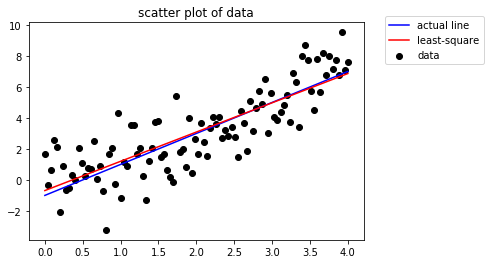

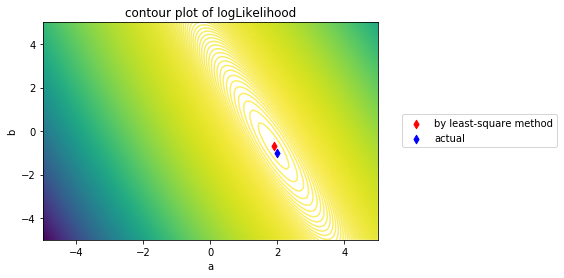

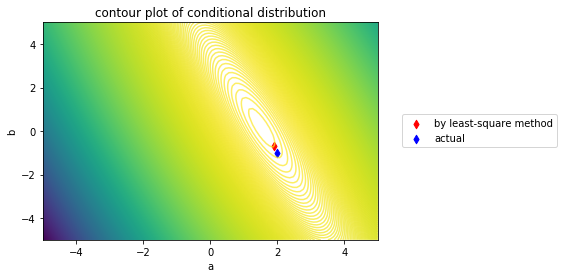

In [7]:
def bayes_and_ls():
    '''
    ベイズ推論と最小二乗法の比較.
    y = ax+b+epsilon_y に従うyを生成する．
    '''
    color_ac = 'blue'
    color_ls = 'red'
    #データ生成
    np.random.seed(0)
    num = 100
    x = np.linspace(0.0,4.0,num)
    variance_y = 1.5#yのノイズの分散
    epsilon_y = np.random.normal(0.0,variance_y,num)#yのノイズ
    params_ac = np.array([2.0,-1.0])#実際のa,b
    y = params_ac[0]*x+params_ac[1]+epsilon_y#観測されたy
    
    #最小二乗法でパラメータ推定
    params_ls = np.polyfit(x,y,1)#1次で近似
    
    #データの描画
    plt.title('scatter plot of data')
    plt.scatter(x,y,label='data',color='black')
    plt.plot(x,params_ac[0]*x+params_ac[1],label='actual line',color=color_ac)
    plt.plot(x,params_ls[0]*x+params_ls[1],label='least-square',color=color_ls)
    plt.legend(bbox_to_anchor=(1.05, 1.05))
    plt.show()
    
    #最尤推定でパラメータ推定
    a_num = 100
    b_num = 100#パラメータa,bの候補の数
    a = np.linspace(-5,5,a_num)
    b = np.linspace(-5,5,b_num)
    X,Y = np.meshgrid(a,b)
    param_product = np.array(list(itertools.product(a,b)))#パラメータの組み合わせ
    y_est = param_product@np.array([x,np.ones(num)])#y = ax+b
    y_ob = np.repeat(y,int(a_num*b_num)).reshape(num,int(a_num*b_num)).T#データのyを繰り返す．
    variance_y_est = 1.0#yのノイズの分散の推定値
    logL = (np.log(1.0/np.sqrt(2.0*np.pi*variance_y_est))-0.5*(y_ob-y_est)**2/variance_y_est).sum(axis=1)#尤度(1次元配列)
    L = logL.reshape(a_num,b_num).T#二次元に直した尤度関数
    plt.title('contour plot of logLikelihood')
    plt.contour(X,Y,L,1000,alpha=0.7)
    plt.xlabel('a')
    plt.ylabel('b')
    plt.scatter(params_ls[0],params_ls[1],label='by least-square method',marker='d',color=color_ls)
    plt.scatter(params_ac[0],params_ac[1],label='actual',marker='d',color=color_ac)
    plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()
    
    #ベイズの定理でパラメータ推定(尤度関数求めるところまでは共通)
    mu = np.array([-1.0,1.0])#a,bの同時分布が正規分布と仮定する．その平均
    covariance = np.array([[0.2,0.1],[0.1,0.2]])#a,bの同時分布の分散．
    p = 1.0/(2.0*np.pi*np.sqrt(np.linalg.det(covariance)))*np.exp(-0.5*(param_product-mu)@np.linalg.inv(covariance)@(param_product-mu).T)
    joint_p = np.diag(p).reshape(a_num,b_num).T
    plt.title('contour plot of conditional distribution')
    plt.contour(X,Y,L+np.log(joint_p),1000,alpha=0.7)
    plt.xlabel('a')
    plt.ylabel('b')
    plt.scatter(params_ls[0],params_ls[1],label='by least-square method',marker='d',color=color_ls)
    plt.scatter(params_ac[0],params_ac[1],label='actual',marker='d',color=color_ac)
    plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()
    
    
    
bayes_and_ls()

# 第2章:基本的な確率分布
## 用語
### エントロピー

エントロピーH$=\displaystyle\int p(x)\ln p(x)$d$x$

一様分布の場合$p(x)=\begin{cases}
\displaystyle\frac{1}{b-a}(a\leq x\leq b)\\
0
\end{cases}$である.

したがってエントロピーは$-\displaystyle\frac{1}{b-a}\ln\left(\frac{1}{b-a}\right)(b-a)=\ln\left( {b-a}\right)$となる.b-aが小さいほどある種デルタ関数のようなものに近づき予測しやすくなると考えると，b-aが小さいほどエントロピーが小さくなるのは直観にかなっている．

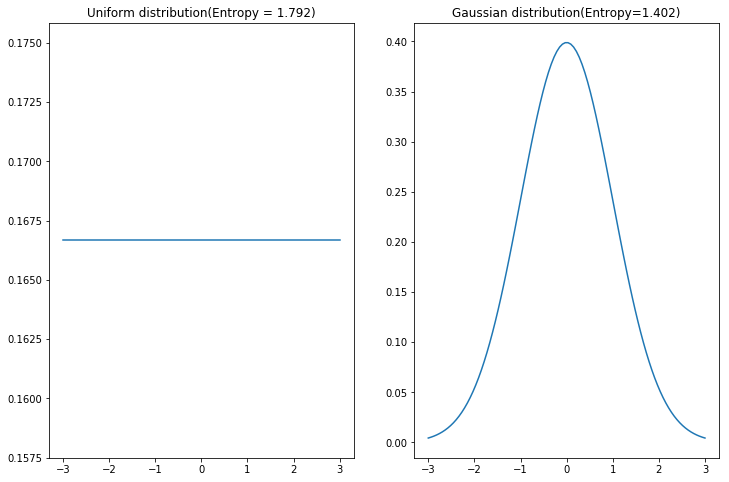

In [54]:
def plot_entropy():
    '''
    各種確率分布のプロットとエントロピー
    '''
    def uniform_entropy(x,a,b,entropy=True):
        '''
        一様分布のエントロピーを返す．
        (a,b)の区間での一様分布についてエントロピーを計算
        '''
        p = 1.0/(b-a)*np.logical_and(x>=a*np.ones(len(x)),x<=b*np.ones(len(x)))#一様分布の確率分布
        p = p[p>0]
        if entropy:
            return -p[0]*np.log(p)[0]*(b-a)#エントロピーを返す
        else:
            return p#確率密度を返す
    
    def gaussian_entropy_i(x,mu,sigma):
        '''
        正規分布の確率密度関数にlogをとったものを返す．これを積分すれば情報量になるので。
        mu:平均
        sigma:標準偏差．sqrt(variance)
        '''
        p = scipy.stats.norm.pdf(x,loc=mu,scale=sigma)#確率分布
        return -p*np.ma.log(p)
        
    def gaussian_entropy(x,mu,sigma):
        '''
        正規分布のエントロピーを返す.
        mu:平均
        sigma:標準偏差
        '''
        return scipy.integrate.quad(gaussian_entropy_i,x[0],x[-1],args=(mu,sigma))
        
    x = np.linspace(-3,3,100)
    a = -3#一様分布の左端
    b = 3#一様分布の右端
    mu = 0.0#ガウス分布の平均
    sigma = 1.0#ガウス分布の標準偏差
    
    #一様分布描画
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.title('Uniform distribution(Entropy = {})'.format(round(uniform_entropy(x,-3,3),3)))
    plt.plot(x,uniform_entropy(x,a,b,entropy=False))
    
    #正規分布描画
    plt.subplot(1,2,2)
    plt.title('Gaussian distribution(Entropy={})'.format(round(gaussian_entropy(x,mu,sigma)[0],3)))
    plt.plot(x,scipy.stats.norm.pdf(x,loc=mu,scale=sigma))
    plt.show()
    
    
plot_entropy()


# 第3章 ベイズ推論による学習と予測
## 離散確率分布の学習と予測
### ベルヌーイ分布の学習と予測

<IPython.core.display.Javascript object>


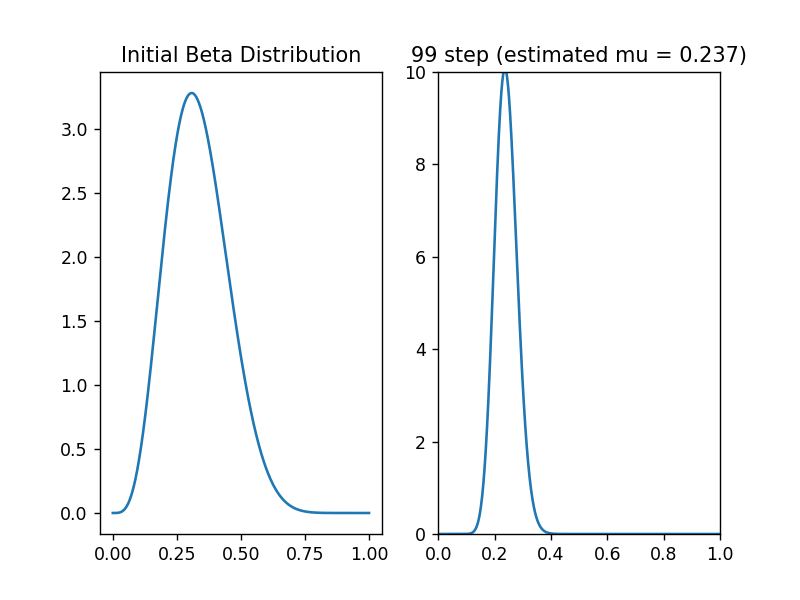

1:23 and 0:77


In [4]:
'''
ベルヌーイ分布の学習のアニメーション．事前分布がベータ分布の場合
'''
%matplotlib notebook
fig, (origin,ax) = plt.subplots(1,2,sharey = False)#originにもとのベータ分布をプロットし，axに学習した後のmuの確率分布をプロットする

x = np.linspace(0,1,1000)#ベルヌーイ分布のパラメータmuの候補
im, = ax.plot([], [])
ax.set_xlim(0,1)
ax.set_ylim(0,10)

a = 5.0#ベータ分布のパラメータ初期値
b = 10.0#ベータ分布のパラメータ初期値
def update(frame):
    '''
    ベルヌーイ分布の学習．
    各フレームまで学習したときの事後分布を格納して返す．
    '''
    global a,b
    a += data[frame]#パラメータの学習
    b += (1-data[frame])
    y = scipy.stats.beta(a,b).pdf(x)
    plt.title('{0} step (estimated mu = {1})'.format(frame,round(x[np.argmax(y)],3)))
    im.set_data(x, y)
    return im,
        
np.random.seed(0)
true_dist = scipy.stats.bernoulli(0.3)#真の確率分布
data = true_dist.rvs(size=100)#観測データ
    
print('1:{0} and 0:{1}'.format(np.sum(data),len(data)-np.sum(data)))
prior_dist = scipy.stats.beta(a,b)
origin.plot(x,prior_dist.pdf(x))
origin.set_title('Initial Beta Distribution')
ani = anm.FuncAnimation(fig, update, blit=True,frames=len(data),repeat=False)
plt.show()


# 第4章 混合モデルと近似推論
## 変分推論
### 多峰性ポアソン分布のデータ生成

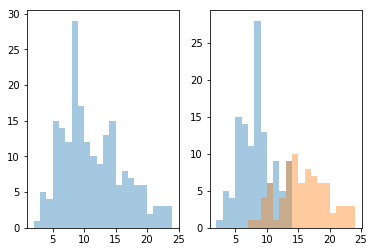

In [2]:
def plot_multimodal_Poi():
    '''
    多峰性ポアソン分布のデータを生成してヒストグラム描画する．
    
    '''
    np.random.seed(0)
    theta_1 = 8.0
    theta_2 = 15.0
    poisson_1 = np.random.poisson(theta_1,120)#多峰性ポアソン分布一つ目から乱数生成
    poisson_2 = np.random.poisson(theta_2, 80)#多峰性ポアソン分布二つ目から生成
    data_given = np.concatenate((poisson_1,poisson_2))
    plt.subplot(1,2,1)
    sns.distplot(data_given,kde=False,bins=np.max(data_given)-np.min(data_given))
    plt.subplot(1,2,2)
    sns.distplot(poisson_1,kde=False,bins=np.max(poisson_1)-np.min(poisson_1))
    sns.distplot(poisson_2,kde=False,bins=np.max(poisson_2)-np.min(poisson_2))
    plt.show()
    return data_given


data_given = plot_multimodal_Poi()

### 変分推論の実行

[14  8  8  8  6  6  5  7  7  4  9  6 13 12  8 14  8  9  3  6 10  6  5  9
 12  6  8 11  6 11  9  8  9  5  5  6  7  8  5  8 10 12 11  7  8  5  6  8
 10 11  8 14  4 12  9  8  7  5  9  9  5 14  8  5  7  8  9 13  4 11  8  8
 10  8  8  5  5  4  8 11  8  3 10  3 13  8  6  8  5 11  6  7  8  9  7  9
  9 13 11  6  7 11  6  5 10  8  8 14  5  8  5  6 12  8  7  7  9  3  3 23
 11  9 15 18 16 15 10 20 18 16 22 19  8 14 14 10 12 19  9 16 16 13 18 19
 14 17 14 15 17 17 12 24 19 17 10 21 14 22 14 17 10 22 14 13 21 13 16 12
 14 20 13 19 19 15 10 12 18 16  9 13 14 14  7 16 13 16 24 10 18 21 18 13
 17 15 13 15 17  9 13]
21


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


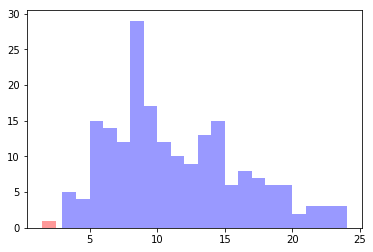

[14 13 12 14 10 12 11 11 10 12 11 10 11 14 12 14 13 11 10 11 10 13 11 13
 11 11 10 14 12 23 11 15 18 16 15 10 20 18 16 22 19 14 14 10 12 19 16 16
 13 18 19 14 17 14 15 17 17 12 24 19 17 10 21 14 22 14 17 10 22 14 13 21
 13 16 12 14 20 13 19 19 15 10 12 18 16 13 14 14 16 13 16 24 10 18 21 18
 13 17 15 13 15 17 13]
14


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


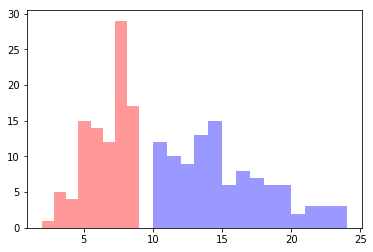

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


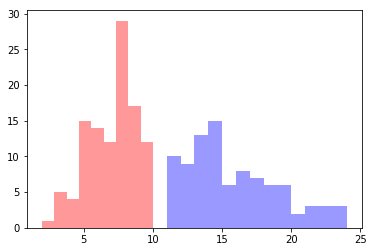

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


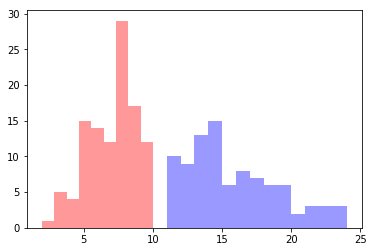

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


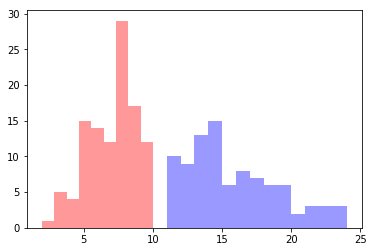

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


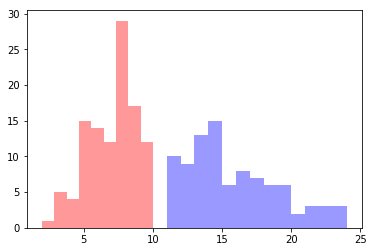

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


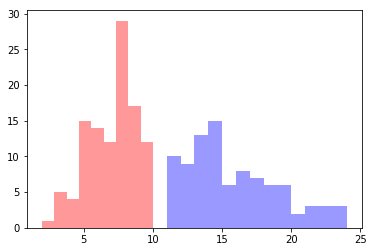

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


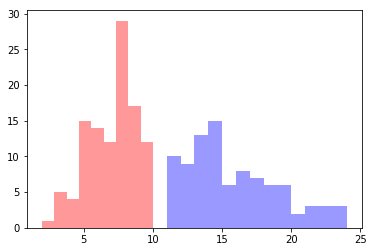

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


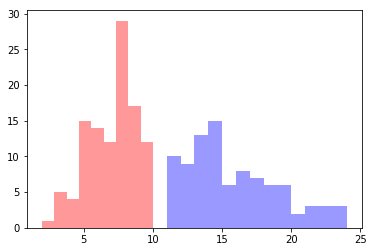

[14 13 12 14 12 11 11 12 11 11 14 12 14 13 11 11 13 11 13 11 11 14 12 23
 11 15 18 16 15 20 18 16 22 19 14 14 12 19 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 21 14 22 14 17 22 14 13 21 13 16 12 14 20 13 19 19 15 12
 18 16 13 14 14 16 13 16 24 18 21 18 13 17 15 13 15 17 13]
13


/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


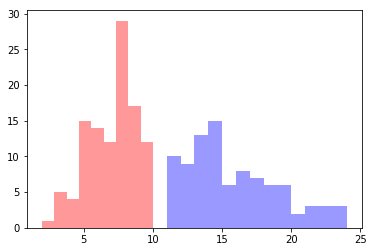

In [144]:
#%%cython -n variational_inference
import numpy as np
import scipy
def variational_inference(data):
    '''
    変分推論で多峰性ポアソン分布のパラメータ推定する．
    data:観測データ
    '''
    def plot_dist():
        x_matrix = np.broadcast_to(data,(category_num,data_num))
        expectation_of_loglambda = np.atleast_2d(scipy.special.digamma(a)-np.log(b))
        expectation_of_logpi     = np.atleast_2d(scipy.special.digamma(alpha)-scipy.special.digamma(np.sum(alpha)))
        eta = np.exp(x_matrix*expectation_of_loglambda.T-np.atleast_2d(a/b).T+expectation_of_logpi.T)
        eta_normalized = eta/np.sum(eta,axis=0)
        classified = (eta_normalized>0.5)[0]
        data_1 = data[classified]
        data_2 = data[~classified]
        
        plt.figure()
        if len(data_1)>0:
            sns.distplot(data_1,color='red',bins = np.max(data_1)-np.min(data_1)+1,kde=False)#kdeはデフォルトでTrue
        if len(data_2)>0:
            sns.distplot(data_2,color='blue',bins=np.max(data_2)-np.min(data_2),kde=False)
        plt.show()
        
    def calc_kldivergence():
        '''
        KLダイバージェンスを計算する
        '''
        pi = scipy.stats.dirichlet(alpha).rvs(size=1)
        theta = np.zeros(category_num)
        for i in range(category_num):
            theta[i] = np.random.gamma
        
    #cdef int maxiter = 10
    #cdef int category_num = 2
    #cdef double a = 1.0,b = 2.0#lambdaが従うガンマ分布のパラメータ
    #cdef double alpha = 1.0#piが従うディリクレ分布のパラメータ
    data_num = len(data)
    maxiter = 1000
    category_num = 2
    a = np.array([2.,30.])
    b = np.array([40.,5.])
    alpha = np.array([100.0,2.0])
    for i in range(maxiter):
        x_matrix = np.broadcast_to(data,(category_num,data_num))
        expectation_of_loglambda = np.atleast_2d(scipy.special.digamma(a)-np.log(b))
        expectation_of_logpi     = np.atleast_2d(scipy.special.digamma(alpha)-scipy.special.digamma(np.sum(alpha)))
        eta = np.exp(x_matrix*expectation_of_loglambda.T-np.atleast_2d(a/b).T+expectation_of_logpi.T)
        eta_normalized = eta/np.sum(eta,axis=0)
        a += np.sum(eta_normalized*x_matrix,axis=1)
        b += np.sum(eta_normalized,axis=1)
        alpha += np.sum(eta_normalized)
        if i%100==0:
            plot_dist()
        
    
    
        
    

variational_inference(data_given)

## Stanでモデリング
### Windows Subsystem for Linux

In [14]:
# -*- coding: <utf-8> -*-
print(data_given)
model = """
data {
  int N;
  int c_num;
  int y[N];
}
parameters {  
  
  positive_ordered[c_num] alpha;//ディリクレ分布のハイパーパラメータ
  positive_ordered[c_num] a;//ガンマ分布のパラメータ
  
  vector<lower = 0>[c_num] b;//ガンマ分布のパラメータ
  
  simplex[c_num] pi;//カテゴリ分布のパラメータの事前分布.simplex型は制約があるということだからパラメータに定義しないといけない？
  vector[c_num] theta;//ポアソン分布のパラメータ
}
model { 
  
  
  for (k in 1:c_num)
      theta[k] ~ gamma(a[k],b[k]);//ポアソン分布のパラメータをガンマ分布から生成
  for (n in 1:N){
      real ps[c_num];
      pi ~ dirichlet(alpha);//カテゴリ分布のパラメータをディリクレ分布から生成.カテゴリ分布は[pi_1, pi_2 ,…pi_K]の配列を返す．型はsimplexで各カテゴリの生起確率
      for (k in 1:c_num){
          real p[c_num];
          //c =  categorical_rng(pi);//stanは離散パラメータ扱えない
          ps[k] = log(pi[k])+poisson_lpmf(y[n]|theta[k]);
      }
      increment_log_prob(log_sum_exp(ps));
  }   
}
"""

sm  = pystan.StanModel(model_code=model)


[14  8  8  8  6  6  5  7  7  4  9  6 13 12  8 14  8  9  3  6 10  6  5  9 12
  6  8 11  6 11  9  8  9  5  5  6  7  8  5  8 10 12 11  7  8  2  5  6  8 10
 11  8 14  4 12  9  8  7  5  9  9  5 14  8  5  7  8  9 13  4 11  8  8 10  8
  8  5  5  4  8 11  8  3 10  3 13  8  6  8  5 11  6  7  8  9  7  9  9 13 11
  6  7 11  6  5 10  8  8 14  5  8  5  6 12  8  7  7  9  3  3 23 11  9 15 18
 16 15 10 20 18 16 22 19  8 14 14 10 12 19  9 16 16 13 18 19 14 17 14 15 17
 17 12 24 19 17 10 21 14 22 14 17 10 22 14 13 21 13 16 12 14 20 13 19 19 15
 10 12 18 16  9 13 14 14  7 16 13 16 24 10 18 21 18 13 17 15 13 15 17  9 13]


UnicodeEncodeError: 'ascii' codec can't encode characters in position 96-112: ordinal not in range(128)

### Ubuntu
https://github.com/stan-dev/pystan/issues/223
'ascii' codec can't encode charactersというエラーが出たので，↑を参考にapi.pyを書き換えた．

Add 'ignore' to pystan/api.py:stanc function. Is this too error-prone?

model_code_bytes = model_code.encode('ascii')

to

model_code_bytes = model_code.encode('ascii', 'ignore')


In [17]:
sm  = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_701b87fa1efdf0a565e633e83a8a2270 NOW.


In [19]:
fit = sm.sampling(data=dict(y = data_given, c_num = 2, N=len(data_given)),iter=10000,chains=2)
fit.plot()
print(fit)

Inference for Stan model: anon_model_701b87fa1efdf0a565e633e83a8a2270.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[0]       0.6  1.1e-3   0.06   0.47   0.56    0.6   0.65   0.72   3297    1.0
pi[1]       0.4  1.1e-3   0.06   0.28   0.35    0.4   0.44   0.53   3297    1.0
theta[0]   7.94  6.6e-3   0.42   7.12   7.65   7.94   8.22   8.74   4078    1.0
theta[1]   15.4    0.01   0.73  14.05   14.9  15.37  15.87  16.92   3856    1.0
lp__     -589.0    0.02   1.26 -592.2 -589.6 -588.7 -588.1 -587.6   4267    1.0

Samples were drawn using NUTS at Tue Jun 19 16:32:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


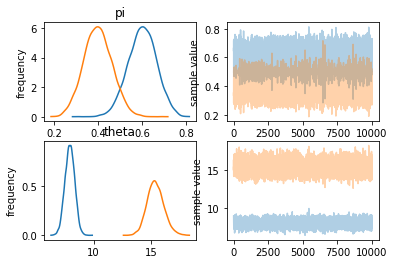

In [20]:
fit.plot()

# テスト

In [50]:
%%cython
import numpy as np
def fib(int n,x):
    print(x)
    cdef int i
    cdef double a=0.0, b=1.0
    ans = np.zeros(n)

    for i in range(n):
        a, b = a+b, a
        ans[i] = a
    print(ans)
    return a

def primes(int kmax):
    cdef int n, k, i
    cdef int p[1000]
    result = []

    if kmax > 1000:
        kmax = 1000

    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i += 1

        if i == k:
            p[k] = n
            k += 1
            result.append(n)
        n += 1
    return result
print(fib(60,3))

3
[1.00000000e+00 1.00000000e+00 2.00000000e+00 3.00000000e+00
 5.00000000e+00 8.00000000e+00 1.30000000e+01 2.10000000e+01
 3.40000000e+01 5.50000000e+01 8.90000000e+01 1.44000000e+02
 2.33000000e+02 3.77000000e+02 6.10000000e+02 9.87000000e+02
 1.59700000e+03 2.58400000e+03 4.18100000e+03 6.76500000e+03
 1.09460000e+04 1.77110000e+04 2.86570000e+04 4.63680000e+04
 7.50250000e+04 1.21393000e+05 1.96418000e+05 3.17811000e+05
 5.14229000e+05 8.32040000e+05 1.34626900e+06 2.17830900e+06
 3.52457800e+06 5.70288700e+06 9.22746500e+06 1.49303520e+07
 2.41578170e+07 3.90881690e+07 6.32459860e+07 1.02334155e+08
 1.65580141e+08 2.67914296e+08 4.33494437e+08 7.01408733e+08
 1.13490317e+09 1.83631190e+09 2.97121507e+09 4.80752698e+09
 7.77874205e+09 1.25862690e+10 2.03650111e+10 3.29512801e+10
 5.33162912e+10 8.62675713e+10 1.39583862e+11 2.25851434e+11
 3.65435296e+11 5.91286730e+11 9.56722026e+11 1.54800876e+12]
1548008755920.0


In [97]:
at = np.array([[1,2,3],[4,5,6]])
b = np.array([4,5])
ans = at*np.atleast_2d(b).T
print(ans)
print(ans/np.sum(ans,axis=0))
print(np.sum(ans,axis=0))

[[ 4  8 12]
 [20 25 30]]
[[0.16666667 0.24242424 0.28571429]
 [0.83333333 0.75757576 0.71428571]]
[24 33 42]


In [154]:
diri = scipy.stats.dirichlet(np.array([3.,4.]))
print(diri.rvs(size=1))

[[0.37483208 0.62516792]]


In [8]:
datum = np.array([[  58.,  115.],
       [  59.,  117.],
       [  60.,  120.],
       [  61.,  123.],
       [  62.,  126.],
       [  63.,  129.],
       [  64.,  132.],
       [  65.,  135.],
       [  66.,  139.],
       [  67.,  142.],
       [  68.,  146.],
       [  69.,  150.],
       [  70.,  154.],
       [  71.,  159.],
       [  72.,  164.]])
weights = np.transpose(datum)[0]
heights = np.transpose(datum)[1]
model = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters { 
  real alpha;#切片
  real beta;
  real<lower=0> sigma;
}
model { 
  y ~ normal(alpha + beta * x, sigma);
}
"""
fit = pystan.stan(model_code=model, data=dict(y=heights, x=weights, N=len(heights)))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e369573bec9718878c97b117ebe714b NOW.
/home/hidekazu/.pyenv/versions/anaconda3-5.2.0/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


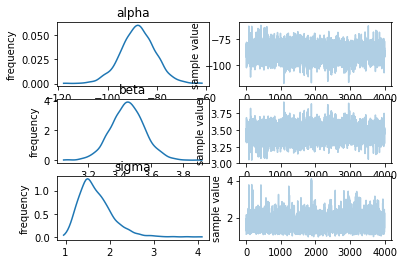

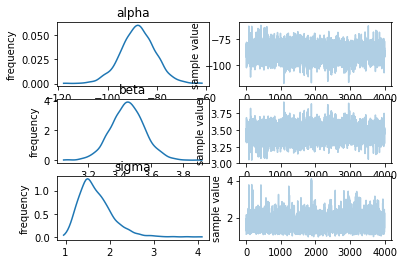

In [5]:
fit.plot()